In [1]:
from cfdmod.use_cases.hfpi import solver, handler, analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pathlib

analysis.set_plt_style()

### Report directory
base_base = pathlib.Path(
    "/mnt/disk01/prd-eng/portfolio-eng/simulation_files/petra_nova_fluidmechanics/comparison/dynamic_analysis"
)
subproject_path = base_base / "subproj_main"
structure_path = base_base / "struct_original"
case_path = subproject_path / "out"
data_path = subproject_path / "forces/"

base_folder = pathlib.Path("/mnt/disk01/prd-eng/cases/petra_nova_fluidmechanics/engmod_case")
experimental_data_path = base_folder / "../comparison/force_by_floor/exp_csv/"

In [2]:
### building dimensions
H = 250.424
Bx = 69.14
By = 90.6
B = max(Bx, By)

dimensions = handler.DimensionSpecs(base=B, height=H)

In [3]:
modes_csv = structure_path / "modes.csv"

n_modes = 12
floors_csv = structure_path / "nodes.csv"
phi_csvs = [structure_path / f"phi_{i}.csv" for i in range(1, n_modes + 1)]

struct_data = solver.HFPIStructuralData.build(
    modes_csv=modes_csv,
    floors_csv=floors_csv,
    phi_floors_csvs=phi_csvs,
    max_active_modes=5,
)

In [4]:
directions = ["000", "030", "060", "090", "120", "150", "180", "210", "240", "270", "300", "330"]
# directions = ["000"]
float_directions = [float(d) for d in directions]
recurrence_periods = [1, 10, 50]
xis = [0.01, 0.02]
recurrence_periods = [50]
xis = [0.01]

In [5]:
directional_forces = {}

for d in directions:
    cf_x_h5 = data_path / f"FX_{d}.h5"
    cf_y_h5 = data_path / f"FY_{d}.h5"
    cm_z_h5 = data_path / f"MZ_{d}.h5"
    forces_data = solver.HFPIForcesData.build(cf_x_h5, cf_y_h5, cm_z_h5)
    directional_forces[float(d)] = forces_data

directional_forces.keys()

dict_keys([0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0, 300.0, 330.0])

In [6]:
wind_analytical = handler.WindAnalysis(directional_data=pd.DataFrame({}), V0=40, U_H_overwrite=40)

In [7]:
results_save = pathlib.Path("/mnt/dev01_fs_shared/waine/repos/cfdmod/output/hfpi_test")
analysis_full = handler.HFPIAnalysisHandler(
    wind_analytics=wind_analytical,
    dimensions=dimensions,
    structural_data=struct_data,
    directional_forces=directional_forces,
    save_folder=results_save,
)

In [8]:
all_parameters = analysis_full.generate_combined_parameters(
    directions=float_directions,
    recurrence_periods=recurrence_periods,
    xis=xis,
)

In [9]:
results = handler.HFPIFullResults.load_all_results(
    results_folder=results_save, parameters=all_parameters
)

In [10]:
max_acceleration = results.filter_by_xi(xi=0.01).get_max_acceleration_by_recurrence_period()

max_acceleration

{50.0: np.float64(0.6604180684022334)}

In [11]:
results_use = results.filter_by_xi(0.01).filter_by_recurrence_period(50)

stats = results_use.get_global_peaks_by_direction()
stats

{'forces_static':     direction         min_x         min_y         min_z         max_x  \
 0         0.0  4.632891e+04 -2.371322e+07  1.994232e+08  9.622982e+06   
 1        30.0 -5.184307e+06 -1.613745e+07  5.029157e+07  2.631232e+06   
 2        60.0 -4.985712e+06 -1.546287e+07  2.455389e+07  5.142198e+05   
 3        90.0 -8.693149e+06 -1.194380e+07 -1.672319e+07 -3.041388e+06   
 4       120.0 -8.802511e+06 -4.613264e+06 -5.246635e+07 -2.806414e+06   
 5       150.0 -7.617695e+06 -5.298515e+05 -8.043977e+07 -1.266815e+06   
 6       180.0 -3.655377e+06  2.631462e+06 -5.054161e+07  2.126591e+06   
 7       210.0 -5.801398e+04  3.736352e+06 -3.478356e+07  8.088243e+06   
 8       240.0  9.203744e+05  4.223104e+06 -4.692517e+07  6.455536e+06   
 9       270.0  2.167199e+06  2.756539e+06 -7.828783e+07  8.451224e+06   
 10      300.0  2.418652e+06  2.433607e+05 -1.158465e+08  1.002753e+07   
 11      330.0  1.297416e+06 -8.080503e+06  2.822415e+06  5.784007e+06   
 
            max_y  

In [12]:
stats["forces_static_eq"]

,direction,min_x,min_y,min_z,max_x,max_y,max_z,mean_x,mean_y,mean_z
0,0.0,-4.641656e+06,-2.538917e+07,-3.665601e+06,1.528822e+07,1.167549e+06,1.900505e+06,3.557334e+06,-1.141332e+07,-3.999570e+05
1,30.0,-9.099424e+06,-1.693973e+07,-1.799179e+06,7.147445e+06,-2.715792e+05,2.265071e+06,-5.240520e+05,-7.644507e+06,7.598440e+02
2,60.0,-6.347355e+06,-1.575455e+07,-1.770242e+06,3.825983e+06,-1.410264e+06,1.274185e+06,-1.471301e+06,-7.429316e+06,2.340289e+04
3,90.0,-1.140463e+07,-1.151555e+07,-8.665997e+05,-2.083158e+05,1.358144e+05,2.112406e+06,-4.760344e+06,-5.210055e+06,5.287259e+05
4,120.0,-1.113693e+07,-1.146711e+07,-1.225576e+06,2.212691e+05,1.058637e+07,2.799655e+06,-4.867675e+06,-9.136517e+05,8.236982e+05
5,150.0,-9.817338e+06,-7.547287e+06,-7.569455e+05,1.040616e+06,1.102028e+07,2.365786e+06,-3.984545e+06,1.522066e+06,7.178672e+05
6,180.0,-6.912847e+06,-1.317852e+06,-6.711845e+05,3.646527e+06,1.392552e+07,2.218401e+06,-1.631896e+06,4.906792e+06,5.830896e+05
7,210.0,-4.683881e+06,2.393628e+05,-1.384361e+06,1.025823e+07,1.712953e+07,2.131101e+06,3.038281e+06,7.531347e+06,3.124627e+05
8,240.0,-2.612817e+06,5.113690e+05,-1.485634e+06,8.054329e+06,1.449031e+07,1.775629e+06,2.449798e+06,7.285076e+06,7.811807e+04
9,270.0,7.377442e+05,-7.716179e+05,-2.604020e+06,1.018901e+07,1.286355e+07,8.011422e+05,4.769425e+06,6.032332e+06,-7.532373e+05


In [13]:
stats["forces_static"]

,direction,min_x,min_y,min_z,max_x,max_y,max_z,mean_x,mean_y,mean_z
0,0.0,4.632891e+04,-2.371322e+07,1.994232e+08,9.622982e+06,-7.560909e+06,6.016186e+08,4.143232e+06,-1.427942e+07,3.638475e+08
1,30.0,-5.184307e+06,-1.613745e+07,5.029157e+07,2.631232e+06,-4.880562e+06,1.624445e+08,-6.540638e+05,-9.299830e+06,9.329816e+07
2,60.0,-4.985712e+06,-1.546287e+07,2.455389e+07,5.142198e+05,-4.504490e+06,1.213939e+08,-2.044000e+06,-9.005642e+06,5.864994e+07
3,90.0,-8.693149e+06,-1.194380e+07,-1.672319e+07,-3.041388e+06,-3.085893e+06,4.700831e+07,-5.285072e+06,-6.409284e+06,7.581190e+06
4,120.0,-8.802511e+06,-4.613264e+06,-5.246635e+07,-2.806414e+06,3.152480e+06,-8.152989e+06,-5.057748e+06,-1.416378e+06,-2.782855e+07
5,150.0,-7.617695e+06,-5.298515e+05,-8.043977e+07,-1.266815e+06,5.277196e+06,-1.816693e+07,-3.801296e+06,2.472806e+06,-4.246177e+07
6,180.0,-3.655377e+06,2.631462e+06,-5.054161e+07,2.126591e+06,1.026546e+07,-1.895777e+06,-1.163736e+06,6.195766e+06,-2.639323e+07
7,210.0,-5.801398e+04,3.736352e+06,-3.478356e+07,8.088243e+06,1.553899e+07,2.912164e+07,3.711429e+06,8.837811e+06,-3.379808e+06
8,240.0,9.203744e+05,4.223104e+06,-4.692517e+07,6.455536e+06,1.514059e+07,6.623746e+05,3.162398e+06,8.618110e+06,-1.822924e+07
9,270.0,2.167199e+06,2.756539e+06,-7.828783e+07,8.451224e+06,1.117461e+07,-1.256121e+07,4.804791e+06,6.415434e+06,-3.813524e+07


In [ ]:
stats["forces_effective"]

,direction,min_x,min_y,min_z,max_x,max_y,max_z,mean_x,mean_y,mean_z
0,0.0,-4.641656e+06,-2.538917e+07,-3.665601e+06,1.528822e+07,1.167549e+06,6.016186e+08,3.850283e+06,-1.284637e+07,1.817238e+08
1,30.0,-9.099424e+06,-1.693973e+07,-1.799179e+06,7.147445e+06,-2.715792e+05,1.624445e+08,-5.890579e+05,-8.472168e+06,4.664946e+07
2,60.0,-6.347355e+06,-1.575455e+07,-1.770242e+06,3.825983e+06,-1.410264e+06,1.213939e+08,-1.757651e+06,-8.217479e+06,2.933667e+07
3,90.0,-1.140463e+07,-1.194380e+07,-1.672319e+07,-2.083158e+05,1.358144e+05,4.700831e+07,-5.022708e+06,-5.809669e+06,4.054958e+06
4,120.0,-1.113693e+07,-1.146711e+07,-5.246635e+07,2.212691e+05,1.058637e+07,2.799655e+06,-4.962712e+06,-1.165015e+06,-1.350243e+07
5,150.0,-9.817338e+06,-7.547287e+06,-8.043977e+07,1.040616e+06,1.102028e+07,2.365786e+06,-3.892921e+06,1.997436e+06,-2.087195e+07
6,180.0,-6.912847e+06,-1.317852e+06,-5.054161e+07,3.646527e+06,1.392552e+07,2.218401e+06,-1.397816e+06,5.551279e+06,-1.290507e+07
7,210.0,-4.683881e+06,2.393628e+05,-3.478356e+07,1.025823e+07,1.712953e+07,2.912164e+07,3.374855e+06,8.184579e+06,-1.533673e+06
8,240.0,-2.612817e+06,5.113690e+05,-4.692517e+07,8.054329e+06,1.514059e+07,1.775629e+06,2.806098e+06,7.951593e+06,-9.075562e+06
9,270.0,7.377442e+05,-7.716179e+05,-7.828783e+07,1.018901e+07,1.286355e+07,8.011422e+05,4.787108e+06,6.223883e+06,-1.944424e+07


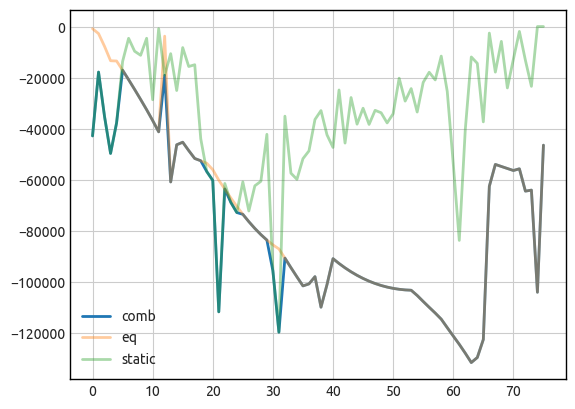

In [ ]:
for param, r in results_use.results.items():
    v_comb = r.get_stats_forces_effective("min")
    v_eq = r.get_stats_forces_static_eq("min")
    v_stat = r.static_results.get_stats_forces_static("min")

    plt.plot(v_comb["x"], label="comb")
    plt.plot(v_eq["x"], label="eq", alpha=0.4)
    plt.plot(v_stat["x"], label="static", alpha=0.4)
    plt.legend()
    plt.show()
    break

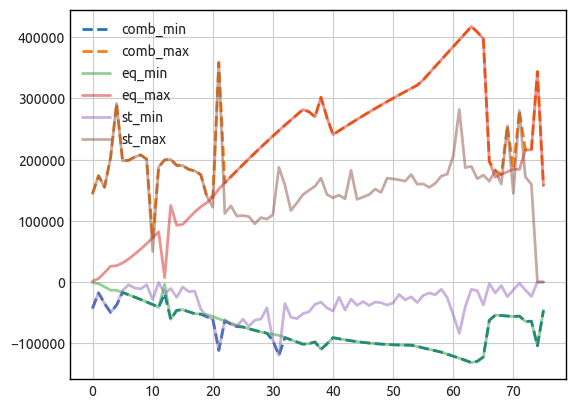

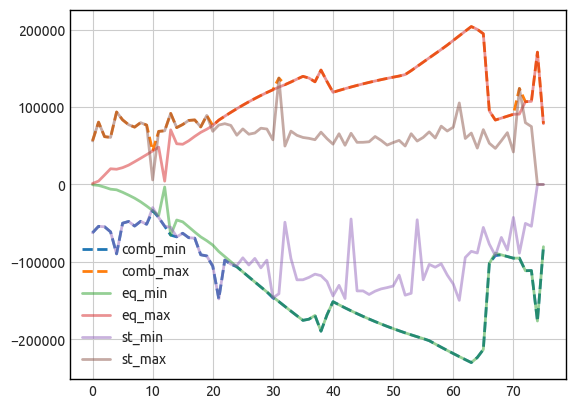

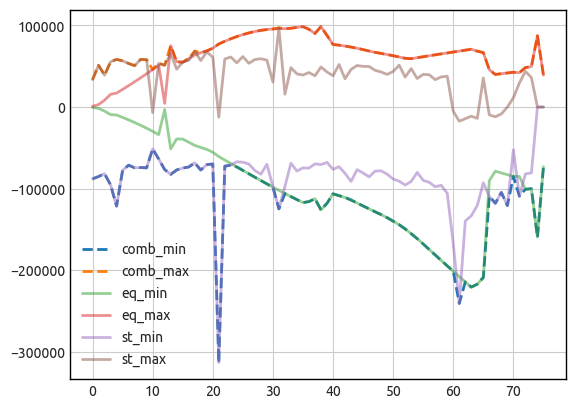

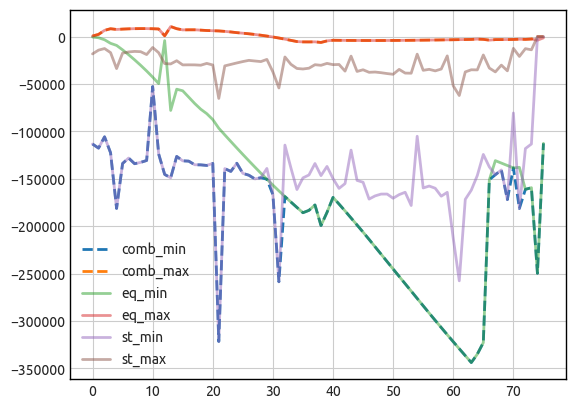

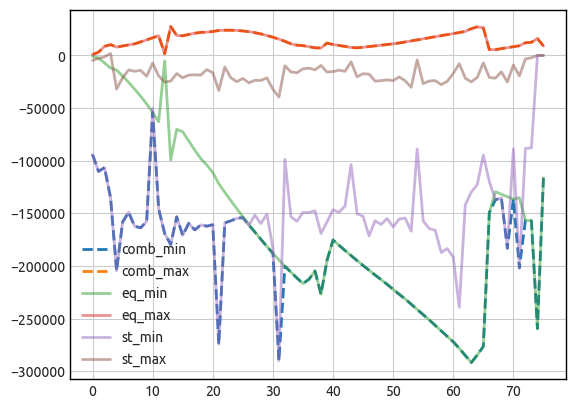

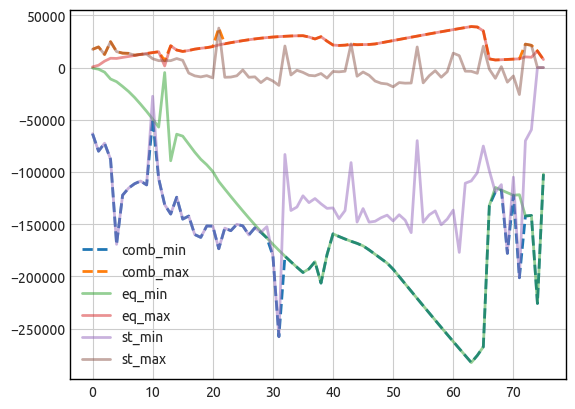

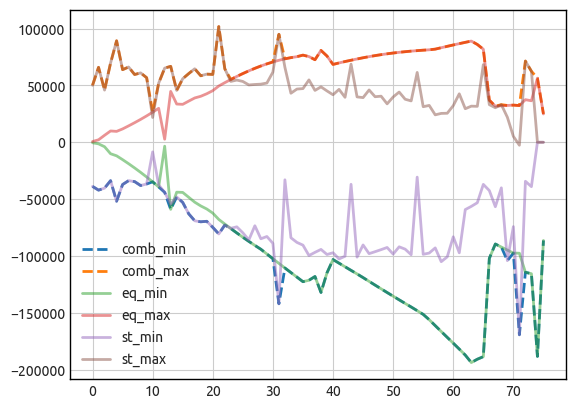

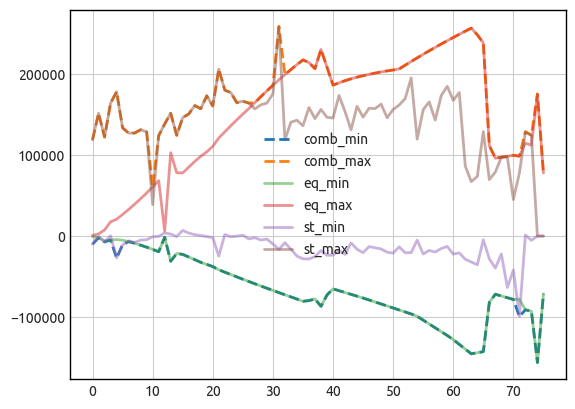

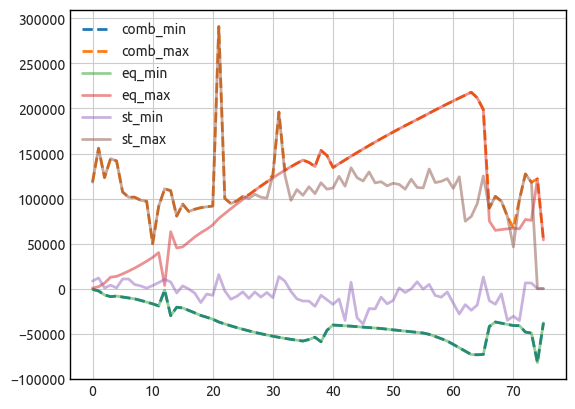

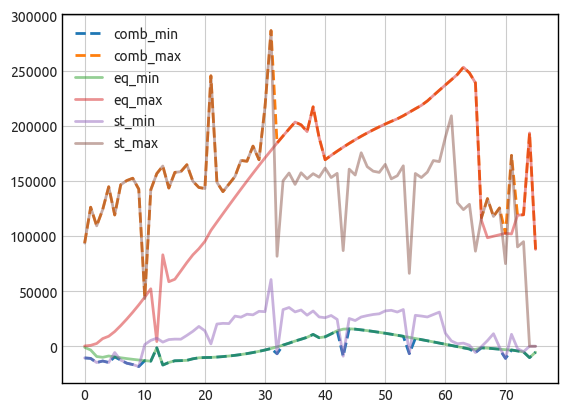

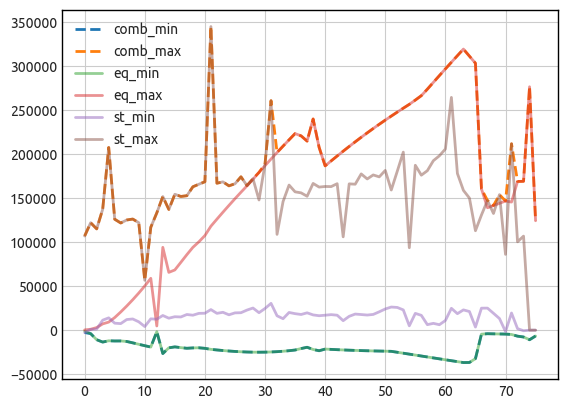

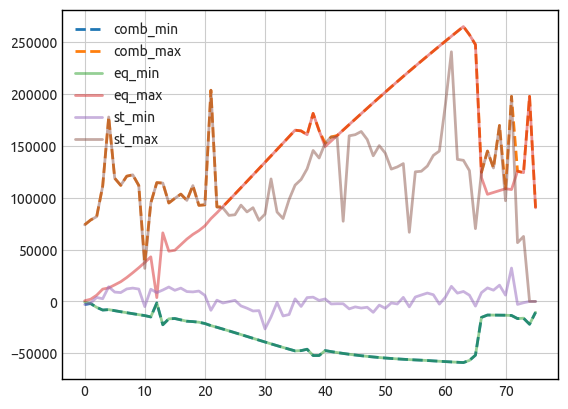

In [ ]:
for direction, r in results_use.join_by_direction().items():
    cmb_force_min = r[0].get_stats_forces_effective("min")
    cmb_force_max = r[0].get_stats_forces_effective("max")
    plt.plot(cmb_force_min["x"], "--", label="comb_min", alpha=1)
    plt.plot(cmb_force_max["x"], "--", label="comb_max", alpha=1)

    eq_force_min = r[0].get_stats_forces_static_eq("min")
    eq_force_max = r[0].get_stats_forces_static_eq("max")
    plt.plot(eq_force_min["x"], label="eq_min", alpha=0.5)
    plt.plot(eq_force_max["x"], label="eq_max", alpha=0.5)

    st_force_min = r[0].static_results.get_stats_forces_static("min")
    st_force_max = r[0].static_results.get_stats_forces_static("max")
    plt.plot(st_force_min["x"], label="st_min", alpha=0.5)
    plt.plot(st_force_max["x"], label="st_max", alpha=0.5)

    plt.legend()
    plt.show()


1900504.7269733648 601618635.5859375
-3665601.399478203 199423161.0625


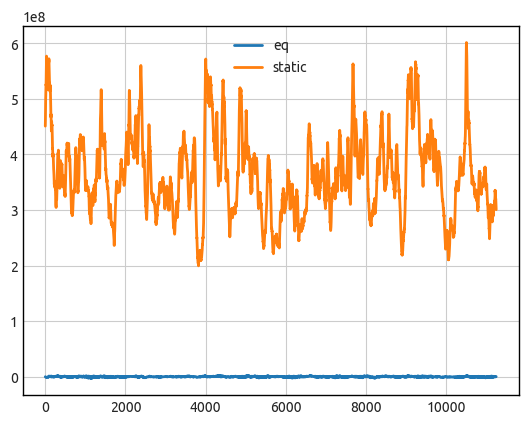

In [17]:
res_0 = list(results_use.results.values())[0]
d = "z"

plt.plot(res_0.global_moments_static_eq[d], label="eq")
plt.plot(res_0.static_results.global_moments_static[d], label="static")
plt.legend()
print(max(res_0.global_moments_static_eq[d]), max(res_0.static_results.global_moments_static[d]))
print(min(res_0.global_moments_static_eq[d]), min(res_0.static_results.global_moments_static[d]))

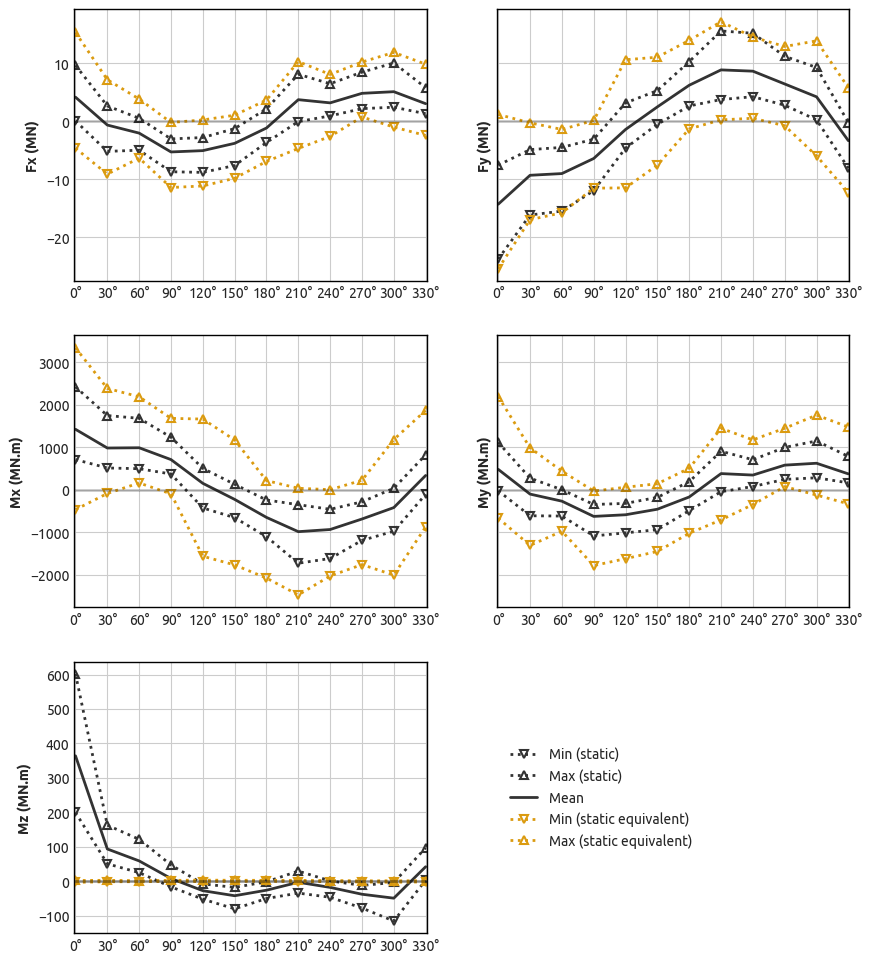

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from cfdmod.use_cases.hfpi import analysis

fig, ax = analysis.plot_global_stats_per_direction(stats)

fig.show()

In [19]:
results_acceleration = results.filter_by_xi(0.01)

max_acc = results_acceleration.get_max_acceleration_by_recurrence_period()
max_acc

{50.0: np.float64(0.6604180684022334)}

In [20]:
import math


def get_codes_max_acceleration(f1: float):
    units_factor = 1
    nbr_6123 = units_factor * 0.01 * 4.08 * f1 ** (-0.445)
    melbourne = (
        units_factor
        * math.sqrt(2 * math.log(600 * f1))
        * (0.68 + math.log(10) / 5)
        * math.exp(-3.65 - 0.41 * math.log(f1))
    )
    nbcc_res = 15
    nbcc_office = 25
    return {
        "NBR 6123": (1, nbr_6123),
        "Melbourne (1992)": (10, melbourne),
        "NBCC residential": (10, nbcc_res),
        "NBCC office": (10, nbcc_office),
    }